# Question Answering

Irrespective of profession, everyone has to wade through ocean of documents at some point to find the information for their questions.  To make matters worse, we're constantly reminded by search engines there are better ways to search! For instance the earch query "When did Marie Curie win her first Nobel Prize?" And google get the correct answer of "1903".

So how was this search done? Google first retrieved 319,000 documents that were relevant to query, then performed a post processing step to extract the answer snippet with the coressponding passage and web page. But for a more trickier question like "Which guitar tuning is best?" We'll get web pages instead of an answer snippet.

The general approach behind this technology is called *question answering*(QA), but the most common is *extractive QA* which involves questions where answers can be identified as a span in a text document, where the document might be a web page, article, legal document etc.

This two stage process of retrieving relevant documents and then extracting answers from this is the basis of many modern QA systems like semantic search, intellegint assistants and automated information extractors. 

> **Note:** We're covering only extractive QA. There are others,
 * community QA Ex: In stack overflow, all the relevant question answer pairs will be retrived for the new Question from user and then using semantic similarity search to find the closest maching answer to this question.
 * long-form QA, which aims to generate complex paragraph-length answers to open ended questions like "Why sky is blue?"
 * QA can be done over tables as well, and transformer models like TAPAS can even peroform aggregations to produce the final answer!

## Use Case

In this notebook, we'll use QA system to solve a common problem facing ecommerce websites: helping consumers evaluate a product by answering specific queries. We'll see that the customer reviews can be used as a rich and challenging source of information for QA. Along the way we'll learn transformers capbality of *reading comprehehsion* and how the model can extract meaning from text.

## Building a Review-Based QA System

Let's say we want to buy a smartphone, and we've question on nightmode camera capbalities. This information is not readily available in product description. We can find the answer for this in reviews by other customers. But we might've to comb throuch thousands of reviews to find the relevant answer. It'll be great if we can have a search like google right? Let's do this using transformers!

### The Dataset

To build our QA system, we'll use [SubQA](https://arxiv.org/abs/2004.14283) dataset, which consists of 10,000+ reviews where each review is associated with a question and answer from one or more sentences from the review. The reviews are about products and services in six domains: TripAdvisor, Restaurants, Movies, Books, Electronics and Grocery.

*Data example*

![alt](../notes/images/7-question-answering/subqa-data-sample.png)

The intersting aspect of this dataset is question(from users), answers(extraced from reviews) are *subjective*. The question on camera quality from user, the quality is subjective to each user and answer might not be from the same point of view question is raised... This is why it's easier to answer fatcual questions like "What's the capital of a country"
Second, important parts of the question do not appear in review at all, so we can't use shortcuts like keyword search or paraphrasing the input question.

Because of these points, SubQA is a greate dataset to benchamrk review-based QA models, sicne user-generated content in the example resembles what we might encounter in the wild.

> **Note:** QA systems are categorized accordig to the domains it has access to while answering the questions. 
  * *Narrow QA* answers question about a single product less documents to search
  * *Open-domain QA* deals with questions about almost anything(eg. amazon's whole product catalog.) more documents to search

### The Dataset

To build our QA system, we'll use [SubQA](https://arxiv.org/abs/2004.14283) dataset, which consists of 10,000+ reviews where each review is associated with a question and answer from one or more sentences from the review. The reviews are about products and services in six domains: TripAdvisor, Restaurants, Movies, Books, Electronics and Grocery.

*Data example*

![alt](../notes/images/7-question-answering/subqa-data-sample.png)

The intersting aspect of this dataset is question(from users), answers(extraced from reviews) are *subjective*. The question on camera quality from user, the quality is subjective to each user and answer might not be from the same point of view question is raised... This is why it's easier to answer fatcual questions like "What's the capital of a country"
Second, important parts of the question do not appear in review at all, so we can't use shortcuts like keyword search or paraphrasing the input question.

Because of these points, SubQA is a greate dataset to benchamrk review-based QA models, sicne user-generated content in the example resembles what we might encounter in the wild.

> **Note:** QA systems are categorized accordig to the domains it has access to while answering the questions. 
  * *Narrow QA* answers question about a single product less documents to search
  * *Open-domain QA* deals with questions about almost anything(eg. amazon's whole product catalog.) more documents to search

### The Dataset

To build our QA system, we'll use [SubQA](https://arxiv.org/abs/2004.14283) dataset, which consists of 10,000+ reviews where each review is associated with a question and answer from one or more sentences from the review. The reviews are about products and services in six domains: TripAdvisor, Restaurants, Movies, Books, Electronics and Grocery.

*Data example*

![alt](../notes/images/7-question-answering/subqa-data-sample.png)

The intersting aspect of this dataset is question(from users), answers(extraced from reviews) are *subjective*. The question on camera quality from user, the quality is subjective to each user and answer might not be from the same point of view question is raised... This is why it's easier to answer fatcual questions like "What's the capital of a country"
Second, important parts of the question do not appear in review at all, so we can't use shortcuts like keyword search or paraphrasing the input question.

Because of these points, SubQA is a greate dataset to benchamrk review-based QA models, sicne user-generated content in the example resembles what we might encounter in the wild.

> **Note:** QA systems are categorized accordig to the domains it has access to while answering the questions. 
  * *Narrow QA* answers question about a single product less documents to search
  * *Open-domain QA* deals with questions about almost anything(eg. amazon's whole product catalog.) more documents to search

To get started , let's download the dataset from hub. we can use the `get_dataset_config_names()` function to find out which subsets are available:

In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In this notebook, we'll be focusing on developing a QA system for Electronic domain. To do that let's download the `electronics` subset.

In [2]:
from datasets import load_dataset
subjqa = load_dataset(
    path="subjqa",
    name="electronics"
)

Found cached dataset subjqa (/Users/jayaprakashsivagami/.cache/huggingface/datasets/subjqa/electronics/1.1.0/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
subjqa

DatasetDict({
    train: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 1295
    })
    test: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 358
    })
    validation: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 255
    })
})

In [4]:
# Features in the dataset
for i in subjqa["train"].features:
    print(i)

domain
nn_mod
nn_asp
query_mod
query_asp
q_reviews_id
question_subj_level
ques_subj_score
is_ques_subjective
review_id
id
title
context
question
answers


Like other question answering datasets on the Hub, SubjQA stores the answers to each questions as a nested dictionary. Let's inspect the answers column.

In [5]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [6]:
# Answers has other nested keys inside
for k, v in subjqa["train"]["answers"][1].items():
    print(k)
    print(v)
    print("")

text
['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up']

answer_start
[1302, 1302]

answer_subj_level
[1, 1]

ans_subj_score
[0.5083333253860474, 0.5083333253860474]

is_ans_subjective
[True, True]



The answers are stored in `text` field, while the starting character indices are provided in `answer_start`. To explore the dataset more easily, let's flatten the nested dict and convert this to a `DataFrame`.

We'll use dataset's [flatten()](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.flatten) to do this.

In [7]:
import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [8]:
dfs["train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   domain                     1295 non-null   object 
 1   nn_mod                     1295 non-null   object 
 2   nn_asp                     1295 non-null   object 
 3   query_mod                  1295 non-null   object 
 4   query_asp                  1295 non-null   object 
 5   q_reviews_id               1295 non-null   object 
 6   question_subj_level        1295 non-null   int64  
 7   ques_subj_score            1295 non-null   float32
 8   is_ques_subjective         1295 non-null   bool   
 9   review_id                  1295 non-null   object 
 10  id                         1295 non-null   object 
 11  title                      1295 non-null   object 
 12  context                    1295 non-null   object 
 13  question                   1295 non-null   objec

In [12]:
dfs["train"].head(2).T

,0,1
domain,electronics,electronics
nn_mod,great,harsh
nn_asp,bass response,high
query_mod,excellent,not strong
query_asp,bass,bass
q_reviews_id,0514ee34b672623dff659334a25b599b,7c46670208f7bf5497480fbdbb44561a
question_subj_level,5,1
ques_subj_score,0.5,0.5
is_ques_subjective,False,False
review_id,882b1e2745a4779c8f17b3d4406b91c7,ce76793f036494eabe07b33a9a67288a


There are quite a few columns, we'll use the below columns for this use case:

1. `title` -> Amazon Standard Identification Number (ASIN) associated with each product
2. `question` -> Question itself
3. `answers.answer_text` -> The span of text in the review labelled by annotator
4. `answers.answer_start` -> The start charachter index of the answer span
5. `context` -> The customer review

Let''s look at these columns alone.

In [21]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df 

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


Observations:

* The queries are not gramatically correct which is quite common in the FAQ sections of ecommerce websites.
* An empty `amswers.text` entry denotes "unanswerable" questions whose answer cannot be found in the review.
* We can use the start index and length of the answer span to slice out the span to get the answer from the text.

In [25]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
start_idx

215

In [26]:
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
end_idx

239

In [27]:
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

In [28]:
sample_df["answers.text"].iloc[0]

array(['this keyboard is compact'], dtype=object)

By predicting the start index and length of the answer, we can create a qa model.

Next, let's get a feel for what types of questions are available in the training set by counting the questions that starts with a few common starting words for questions:

In [51]:
counts = {}
# Here we're assuming all users will start the question with capital letter...
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    # Get the questions start with q using value_counts()
    # value_counts() returns count for True(1st index) and False(0th index)
    # Get true from ther value_counts() and save it to dict
    false_true = dfs["train"]["question"].str.startswith(q).value_counts()
    if len(false_true) == 2:
        counts[q] = false_true[1]
    else:
        counts[q] = 0
counts

{'What': 236,
 'How': 515,
 'Is': 100,
 'Does': 45,
 'Do': 83,
 'Was': 12,
 'Where': 28,
 'Why': 21}

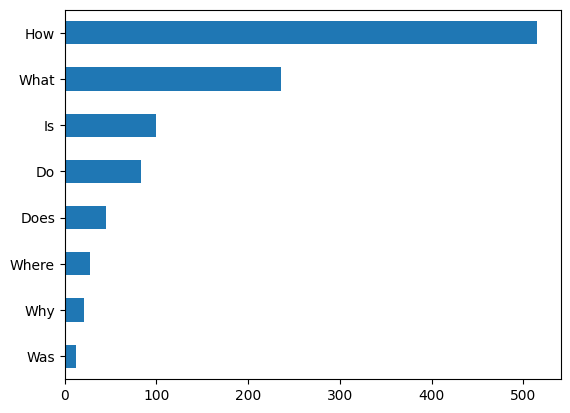

In [53]:
# Let's plot this
import matplotlib.pyplot as plt
pd.Series(counts).sort_values().plot.barh()
plt.show()

Most common questions begins with "How", "What", and "Is", let's have a look at some examples:

In [55]:
for question_type in question_types:
    print(question_type)
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)].sample(n=3, random_state=42)["question"]
    ):
        print(question)
    print("")

What
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?

How
How is the camera?
How do you like the control?
How fast is the charger?

Is
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?

Does
Does the camera include control?
Does the product have good quality?
Does this provide enough storage?

Do
Do you have a price for a shoes?
Does this headphone excellent?
Do they come with the manufacturer's seal?

Was
Was the drive absolutely perfect?
Was prompt the delivery?
Was the mountain high?

Where
Where is the cheapest price?
Where can I send to setup my device?
Where do I have a drawer full of headphones?

Why
Why do I have an incredible sound?
Why is customer service excellent?
Why this feature affect the move?



## Question Answering Dataset history

 The (question, review, [answer setences]) format of SubjQA(used in ![7-question-answering.ipynb notebook usecase for q](../notebooks/7-question-answering.ipynb)) is commonly used in extractive QA datasets and was pioneered in Stanford Question Answering Dataset(SQuAD). 

 * SQuAD is a famous dataset to test the abilit of machines(models) to read a passage of text and answer questions about it
 * This dataset was created from several hundred articles from wikipedia, where each of the article was partioned into paragraphs. Then crowdworkers were asked to generate questions and answers for each paragraph.
 * In the first crowdworkers version of SQuAD, answers for questions were guaranteed to be in paragraphs.
 * Soon sequence to sequence models outperformed humans and predicted spans of answers for question in the context(paragraphs, reviews etc.)
 * SQuAD 2.0 was created by augmenting SQuAD 1.1 with a set of adversial questions that were relevant to the passage but can't be answered from the passage contents alone. This became a better benchmark for evaluation qa capabalities of machines.
 * SOTA models as of 2022 with most models since 2019 surpasses human performance.
    *qa sota models timeline*

    ![alt](../notes/images/7-question-answering/qa-sota-models.png)
* However this superhuman performance does not appear to reflect genuine reading comprehension, since answers to these "unanswerable" questions can be found by looking at antonymns in passages. 
* To address these problems Google released the Natural Questions (NQ) dataset which involves fact-seeking questions obtainef from Google Search users.
* The answers in NQ are much longer than in SQuAD and present a more challenging benchmark.

```
NQ >> SQuAD2.0 >> SQuAD
```

Now let's dive into how transformers can extract answers from text.